# Table of Contents
* [Conventions](#Conventions)
* [Goal](#Goal)
* [Datasets](#Datasets)
* [Hyperparameters](#Hyperparameters)
* [Parts and Processes](#Parts-and-Processes)
  * [Build initial word list](#Build-initial-word-list)
  * [Abstraction Tree](#Abstraction-Tree)
    * [Build initial abstraction tree](#Build-initial-abstraction-tree)
    * [Grow abstraction tree](#Grow-abstraction-tree)
    * [DIST2LEAF](#DIST2LEAF)
    * [NUM_LEAVES](#NUM_LEAVES)
  * [Display Tree](#Display-Tree)
  * [Get Examples](#Get-Examples)
    * [Find Positive Examples](#Find-Positive-Examples)
    * [Find Negative Examples](#Find-Negative-Examples)
  * [Train/Test Datasets](#Train/Test-Datasets)
  * [Training](#Training)
  * [Evaluate (Negative Examples)](#Evaluate-%28Negative-Examples%29)
  * [Evaluate (vs other classifiers (distractors))](#Evaluate-%28vs-other-classifiers-%28distractors%29%29)
* [TODO](#TODO)

# Conventions
Some conventions used in this document.<br>
<br>
**bold** - A **bold** word represents an important concept or idea that may not be commonly known.<br>
**code block** - A word inside a <code>code block</code> is a variable name.  These code blocks may also contain code within the program.<br>
**(PFI)** - Possible Future Improvement - These are notes on ways we might improve upon some of the code/processes/ideas in the project.<br>
<br>
Most sections of this document correspond to some part of the code.  Often a section will begin with a code block containing a <code style="color:lightblue"># Comment</code> or <code style="color:blue">function()</code>.  These correspond to actual comments or functions in the code.

# Goal
Create a set of abstract word embeddings from concrete word embeddings.

# Datasets
**wac** - A set of word embeddings generate from images.<br>
**WordNet** - A network of words/concepts showing hypernym/hyponym relationships.<br>
**Concreteness Ratings** - A list of words along with their concreteness ratings.<br>

# Hyperparameters
`concreteness_threshold` - Words with a **Concreteness Rating** below this threshold will not be considered a concrete word.<br>
`pos_count` - Number of positive examples we want for each classifier.<br>
`neg_count` - Number of negative examples we want for each classifier.<br>
`test_pct` - Percent of text examples during the train/test split.

# Parts and Processes

## Build initial word list
We start with a list of words that are common among all three datasets.<br>
Using **Concreteness Ratings** we then extract words at or above the <code>concreteness_threshold</code>.<br>
Using **wac** we grab the embedding for each word.<br>
Using **WordNet** we convert these words into concepts (aka **Synsets**).<br>
All of this is put into a pandas DataFrame called `abstraction_tree`.<br>

### Note: Words vs Concepts (Synsets)
Every word can represent more than one concept.  Every concept can be represented by multiple words. For example, "block" and "cube" represent one concept, while "block" and "obstruct" represent a different concept.  We use the word "block" to represent two different concepts.  This can make talking about concepts difficult.  To make things easier, it would be nice if we could have a single word (or symbol) that represented a single concept.  This is where **Synsets** come in.

A **Synset** ("Synonym set") is a symbol that represents a single concept in a one to one relationship.

Because **WordNet** deals with concepts it uses these **Synsets** instead of words.

**wac** contains a list of words (not concepts), so we must somehow match a word to one of its concepts.  To do this, we take the first Synset associated with a word in **WordNet**, and use that in our initial list of concrete concepts.  Because we only take the first concept, most other concepts are not being considered.  (PFI) It may be beneficial to find a way to use these other concepts as well.

## Abstraction Tree
Generally speaking the synsets in WordNet are organized into hypernym/hyponym relationships.  In general, a hypernym will be a more abstract concept than a hyponym.  And in an ideal world, every hyponym in WordNet will have a single hypernym that is more abstract.  And every hypernym will have a set of hyponyms that are more concrete.  In an ideal world, every hyponym will be in the set of its hypernym's hyponyms.  In an ideal world, there would be no loops in this structure.  But this is not the ideal world.

This is where the idea of an **abstraction tree** comes in.  Our abstraction tree will clean up WordNet and form it into a sort of tree.  This tree will have concrete synsets as leaf nodes with branches being more abstract concepts based on the leaf nodes.

Using this abstraction tree we can take an abstract concept and find a set of concrete concepts that are used to build it.  We can then take the embeddings of these concrete concepts to train a classifier and create an embedding for the more abstract concept.

### Build initial abstraction tree
<code style="color:blue">init_abstraction_tree(min_rating=8)</code><br>

<code style="color:lightblue"># Get True Leaf Synsets</code><br>
<code style="color:lightblue"># Remove leaves that are ancestors of other leaves</code><br>
Some of the concepts in our initial list (`leaf_synsets`) will have hypernyms that are also in the list.  We want to get rid of these hypernym concepts.  Even though they are considered "concrete" and have embeddings, we will treat them as more abstract, and build our own embeddings for them.

(PFI) Is there a way to incorporate these into our system?

<code style="color:lightblue"># Remove leaves that have the same Synset</code><br>
To make things easier, we make sure every leaf points to one and only one synset.  I tried to leave these in, but it increased the complexity of code further down the line, and I don't see a benefit to them.

(PFI) Would there be a benefit to leaving these in?

### Grow abstraction tree
<code>grow_abstraction_tree(abstraction_tree)</code>

Starting with the initial list of leaf nodes, we will build a list of more abstract concepts.

**Strategy**<br>
* Loop through the current list of synsets (`synset_list`).<br>
 * Find a hypernym for each.
 * If the hypernym is not in `synset_list`, add it to the `abstraction_tree` and `synset_list`.
 * Set the appropriate hypernyms and hyponyms
</code>

Note: We are adding to `synset_list` as we are looping through it.  This is generally frowned upon but in this case it makes for slightly cleaner code.

### DIST2LEAF
<code style="color:lightblue"># Set DIST2LEAF</code><br>
This tracks the distance to the *furthest* leaf.  This indicates a sort of abstraction level, and is used to find negative examples.

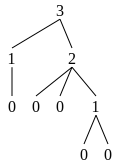

In [1]:
from nltk.tree import Tree
Tree.fromstring('(3 (1 0) (2 0 0 (1 0 0)))')

<code style="color:blue">update_dist2leaf(synset, dist)</code><br>
During grow_abstraction_tree(), when a hyponym is attached to a hypernym, we may need to update dist2leaf for the hypernyms up the chain.

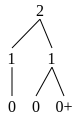

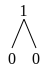

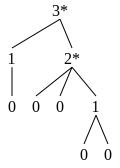

In [2]:
orig = Tree.fromstring('(2 (1 0) (1 0 0+))')
new = Tree.fromstring('(1 0 0)')
result = Tree.fromstring('(3* (1 0) (2* 0 0 (1 0 0)))')
display(orig, new, result)

### NUM_LEAVES
<code style="color:lightblue"># Set NUM_LEAVES</code><br>
Each node will keep track of the number of leaves under it.  This will be used to determine if the node is a leaf, or if it can have a classifier (thus an embedding).

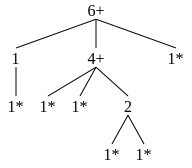

In [3]:
Tree.fromstring('(6+ (1 1*) (4+ 1* 1* (2 1* 1*)) 1*)')

In the above example, using `pos_count=3`:<br>
(**+**) - Indicates a node that will eventually have a classifier and embedding.<br>
(**\***) - Indicates a leaf node and will already contain an embedding, but no classifier.<br>
All other nodes have too few leaves to contain a classifier and are not leaf nodes, so they will not have an embedding.<br>

## Display Tree
<code style="color:blue">build_display_tree(df, root_synset, char_limit=20, call_limit=500)</code><br>
<code style="color:blue">build_display_tree_safe(df, root_synset, char_limit=20)</code><br>

Builds a display tree starting at the `root_synset`.

The number of calls that can be made to <code style="color:blue">build_display_tree_safe(df, root_synset, char_limit=20)</code> is limited by `display_tree_call_limit`.  This will keep the tree from growing too large.

Building a tree with `concreteness_threshold = 9` will show a nice example.

## Get Examples

Now that we have an `abstraction_tree` we can use it to get a list of hyponym examples for each hypernym.

### Find Positive Examples
<code style="color:blue">find_positive_examples(synset, depth=100)</code><br>
Start by looking at the direct hyponyms for the synset.<br>
Then, if there aren't enough nodes with embeddings (or capable of having an embedding), "expand" each node in the list by looking at the hyponyms under it.<br>
Repeat these steps until we have a complete list of embedding capable nodes.<br>
<br>
Note: We know that a node is capable of having an embedding (and a set of examples) if `NUM_LEAVES` for the node is >= `pos_count`<br>
<br>
The following shows the first step of this process with `pos_count=3`.  'a' is the hypernym we are trying to find examples for, and nodes marked with (\*) are examples currently in the list.

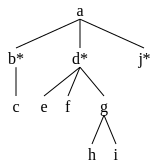

In [4]:
Tree.fromstring('(a (b* c) (d* e f (g h i)) (j*))')

Here we see we have three examples, but 'b' isn't capable of having an embedding, so we'll need to expand.

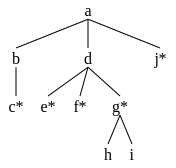

In [5]:
Tree.fromstring('(a (b c*) (d e* f* (g* h i)) (j*))')

Here, 'j' wasn't able to expand, so we stay there.  'b' was able to expand to 'c'. And 'd' expended to 'e', 'f', and 'g'.  This is 5 nodes, but we notice 'g' isn't capable of having an embedding, so the final results is 4 nodes ('c', 'e', 'f', and 'j').<br>
<br>
Note, this is more than `pos_count`.  When we are looking for positive examples, we will sometimes get more than we are looking for (but never less).

### Find Negative Examples
<code style="color:blue">find_negative_examples(synset, pos_examples)</code><br>
This one is a little different than finding positive examples.<br>
<br>
We start by getting a list of all the possible synsets.<br>
Then we remove any synset that isn't capable of having an embedding.<br>
Then we remove any synset that is more abstract (has a larger `DIST2LEAF`) than the one we're looking at.<br>
 - Note: This is important for the training step.  We can't use a synset that doesn't have an embedding yet.
 - (PFI) Should we consider other ways to define abstractness?<br>
 - (PFI) Should we even be removing more abstract examples?<br>
 
Then we remove the positive example from the list.<br>
 - (PFI) Should we remove *every* hyponym under the synset, or just the ones used in the positive example?<br>

We now have a set of examples we can randomly pull from.


## Train/Test Datasets
<code style="color:lightblue"># Build Train/Test datasets</code><br>
<code style="color:blue">fill_out_train_test()</code><br>
Here we take the list of positive and negative examples we found earlier and construct train and test sets.  We are storing these sets in `abstraction_tree` for ease of use.<br>
<br>
Note: The `y` values are 1's or 0's, however, the `X` values are synsets, not the actual embeddings.  We don't have embeddings for the abstract synsets yet.  We will get these during training.

## Training
<code style="color:lightblue"># Train</code><br>
<code style="color:blue">build_classifiers()</code><br>
We need to build classifiers for each of our abstract synsets.  Once the classifier is built, we will grab the coefficients to use as the embedding for the synset.<br>
<br>
Problem: Some hypernyms have examples that are not leaf synsets.  These non-leaf synsets will not start out with an embedding.  So how do we make sure they have an embedding before their hypernyms?<br>
<br>
Solution: We start with our least abstract synset and work our way up.  This will guarantee all examples will have an embedding by the time we need to use them in a classifier.

## Evaluate (Negative Examples)
There are a few ways to evaluate our new classifiers.<br>
The first is by evaluating each classifier individually using its `X_TEST` and `Y_TEST` sets.<br>
<br>
<code style="color:lightblue"># Random Baseline (For a single classifier)</code><br>
Because each hypernym has a different number of positive and negative sets, we'll have to go through and count each to determine what the random baseline is.<br>
At the time of this writing it's 0.35.<br>
In general this will be close to the ration `pos_count / (neg_count + pos_count)`<br>
<br>
<code style="color:lightblue"># Most Common Baseline (For a single classifier)</code><br>
Because of the nature of binary classifiers, the most common baseline will just be 1-random_baseline.<br>
TODO: verify this<br>
At the time of this writing it's 0.65.<br>
<br>
<code style="color:lightblue"># Evaluate (vs negative examples)</code><br>
Run through all classifiers to test them and get a final accuracy score.<br>
At the time of this writing it's 0.76666...<br>
This is beating the baseline so that's good.

## Evaluate (vs other classifiers (distractors))
<code style="color:lightblue"># Evaluate (vs other classifiers)</code><br>
This evaluation method will pit a classifier against a number of distractor classifiers.  The classifier that assigns the highest score is the winner.  Idealy we'll want the "gold" classifier to win (`gold_ss`).<br>
<br>
<code style="color:blue">test_classifier_single(x_ss, gold_ss, num_distractors=5)</code><br>
This will run a single test.  Given one positive example (`x_ss`) and a gold classifier (`gold_ss`) will the gold classifier be able to beat a number of distractors?<br>
<br>
Note: The \_ss part of `x_ss` and `gold_ss` indicates that these are synsets.  This function will look in `abstraction_tree` to find the appropriate embedding and classifier.<br>
<br>
Note: Some distractor classifiers might have `x_ss` as a positive example.  Some have even been trained on `x_ss`.  For this reason we'll need to disqualify these distractors.<br>
<br>
Note: We return `score` (1 or 0) along with the number of possible options (number of distractors + 1).  This will be used later to get a final score and calculate a baseline.<br>
<br>
(PFI) Is there a better way to do any of this?<br>
<br>
<code style="color:blue">test_classifier_full(gold_ss, num_distractors=5)</code><br>
This function will run through all positive `X_TEST` examples of a synset and evaluate its classifier vs some distractors using `test_classifier_single()`<br>
<br>
<code style="color:lightblue"># Evaluate (vs other classifiers)</code><br>
This is code that will run through all calssifiers and test them to get some final grand score.<br>
At the time of this writing, this is still a work in progress.<br>
TODO: Make this into a function.

# TODO
* Put all of this into a nice neat little class to help with testing hyperparameters.
* Run through more tests.
* Find a good way to display test results.
* Convert the synsets into words with their embeddings?
 * Test these new word embeddings?